In [ ]:
import scipy.io
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2

/tmp/ipykernel_407926/3173433645.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cellreg_int = df_cellreg.applymap(lambda x: int(x) if not np.isnan(x) else np.nan)
/tmp/ipykernel_407926/3173433645.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_caiman_int = df_caiman.applymap(lambda x: int(x) if not np.isnan(x) else np.nan)


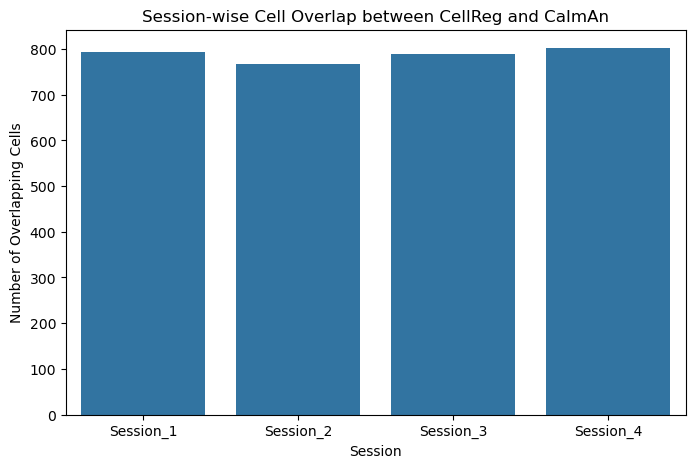

Exact matches across all sessions: 1


In [ ]:
# Load CellReg output from .mat file
cellreg_path = "/media/toor/T7Shield/Mouse1637/Linear/Cellreg_processed/test_registration/cellRegistered_20250121_172313.mat"
with h5py.File(cellreg_path, "r") as f:
    dataset_ref = f['cell_registered_struct']['cell_to_index_map'].ref
    cell_to_index_map = np.array(f[dataset_ref]).T  # Transpose for correct format

# Replace 0s with NaN (to match CaImAn format)
cell_to_index_map[cell_to_index_map == 0] = np.nan

# Load CaImAn output (.npy file)
npy_path = "/media/toor/T7Shield/Mouse1637/Linear/Caiman_registration/assignments_test.npy"
caiman_assignments = np.load(npy_path)

# Convert to DataFrames for easier comparison
df_cellreg = pd.DataFrame(cell_to_index_map, columns=[f"Session_{i+1}" for i in range(cell_to_index_map.shape[1])])
df_caiman = pd.DataFrame(caiman_assignments, columns=[f"Session_{i+1}" for i in range(caiman_assignments.shape[1])])

# Convert all cell IDs to integers, maintaining NaNs
df_cellreg_int = df_cellreg.applymap(lambda x: int(x) if not np.isnan(x) else np.nan)
df_caiman_int = df_caiman.applymap(lambda x: int(x) if not np.isnan(x) else np.nan)

# Compute session-wise overlap
session_wise_overlap = []
for session in df_cellreg_int.columns:
    session_overlap = len(set(df_cellreg_int[session].dropna()).intersection(set(df_caiman_int[session].dropna())))
    session_wise_overlap.append(session_overlap)

# Compute exact matches across all sessions
exact_match = pd.merge(df_cellreg_int.dropna(), df_caiman_int.dropna(), how="inner").shape[0]

# Bar plot: Session-wise overlap
plt.figure(figsize=(8, 5))
sns.barplot(x=df_cellreg_int.columns, y=session_wise_overlap)
plt.xlabel("Session")
plt.ylabel("Number of Overlapping Cells")
plt.title("Session-wise Cell Overlap between CellReg and CaImAn")
plt.show()

# Output exact match count
print(f"Exact matches across all sessions: {exact_match}")


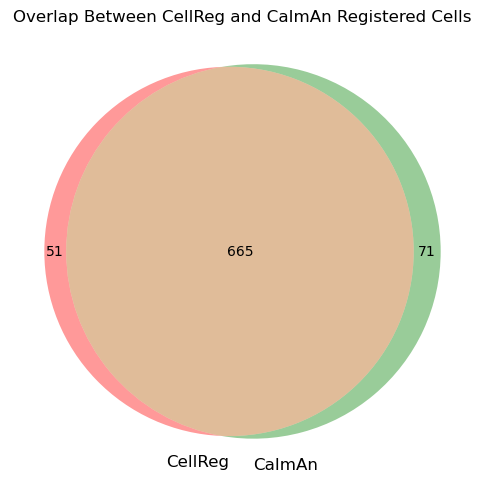

In [ ]:
# Get the unique cell IDs from both datasets (ignoring NaNs)
cellreg_cells = set(df_cellreg.dropna().values.flatten())
caiman_cells = set(df_caiman.dropna().values.flatten())

# Remove NaN values (converted to float type)
cellreg_cells.discard(np.nan)
caiman_cells.discard(np.nan)

# Create the Venn diagram
plt.figure(figsize=(6, 6))
venn2([cellreg_cells, caiman_cells], set_labels=("CellReg", "CaImAn"))

# Add title
plt.title("Overlap Between CellReg and CaImAn Registered Cells")
plt.show()


<Figure size 800x500 with 0 Axes>

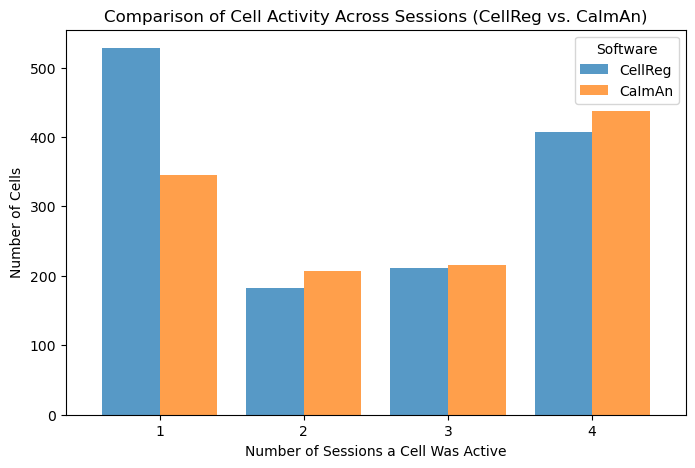

In [12]:
# Count the number of cells active in 1, 2, 3, or 4 sessions for each software
cellreg_active_counts = df_cellreg_int.notna().sum(axis=1).value_counts().sort_index()
caiman_active_counts = df_caiman_int.notna().sum(axis=1).value_counts().sort_index()

# Create a DataFrame for visualization
activity_comparison_df = pd.DataFrame({
    "CellReg": cellreg_active_counts,
    "CaImAn": caiman_active_counts
}).fillna(0)  # Fill missing values with 0

# Plot the comparison
plt.figure(figsize=(8, 5))
activity_comparison_df.plot(kind="bar", figsize=(8, 5), alpha=0.75, width=0.8)
plt.xlabel("Number of Sessions a Cell Was Active")
plt.ylabel("Number of Cells")
plt.title("Comparison of Cell Activity Across Sessions (CellReg vs. CaImAn)")
plt.xticks(rotation=0)
plt.legend(title="Software")
plt.show()

In [13]:
# Extract the cell indices from the first session for both software
cellreg_first_session = set(df_cellreg_int["Session_1"].dropna())
caiman_first_session = set(df_caiman_int["Session_1"].dropna())

# Identify persistent cells in both software
persistent_cellreg = set(df_cellreg_int[df_cellreg_int.notna().all(axis=1)]["Session_1"])
persistent_caiman = set(df_caiman_int[df_caiman_int.notna().all(axis=1)]["Session_1"])

# Overlapping persistent cells (cells active in all four sessions in both software)
persistent_overlap = persistent_cellreg.intersection(persistent_caiman)

# Unique persistent cells in each software
unique_persistent_cellreg = persistent_cellreg - persistent_caiman
unique_persistent_caiman = persistent_caiman - persistent_cellreg

# Count the numbers
num_persistent_overlap = len(persistent_overlap)
num_unique_persistent_cellreg = len(unique_persistent_cellreg)
num_unique_persistent_caiman = len(unique_persistent_caiman)

# Create a summary DataFrame
persistent_summary_df = pd.DataFrame({
    "Persistent in Both": [num_persistent_overlap],
    "Persistent Only in CellReg": [num_unique_persistent_cellreg],
    "Persistent Only in CaImAn": [num_unique_persistent_caiman]
})


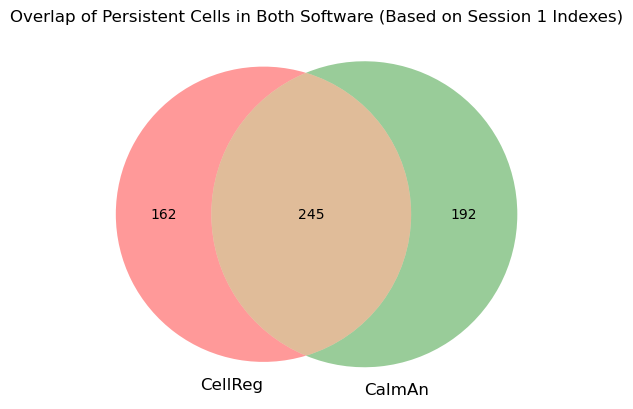

In [14]:
# Create a Venn diagram to visualize the overlap of persistent cells
plt.figure(figsize=(6, 6))
venn2([persistent_cellreg, persistent_caiman], set_labels=("CellReg", "CaImAn"))

# Add title
plt.title("Overlap of Persistent Cells in Both Software (Based on Session 1 Indexes)")
plt.show()
